In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
import scipy.cluster.hierarchy as sch 
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy as clust

from sklearn import preprocessing as prep
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, RANSACRegressor
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import RidgeClassifierCV
from sklearn.cluster import AgglomerativeClustering as ac
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio

import seaborn as sns
import kaleido

import statsmodels.api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ToyotaCorollaPrice

Our aim is to predict the price of the cars in dataframe

## EDA

In [2]:
dftoyota = pd.read_csv('ToyotaCorolla.csv') # Reading data
print('Missing values=',sum(dftoyota.isnull().sum())) # Checking missing values
print('duplicated values =',sum(dftoyota[dftoyota.duplicated()].count())) # Checking duplicate values
dftoyota.info()

Missing values= 0
duplicated values = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1436 non-null   int64 
 1   Model              1436 non-null   object
 2   Price              1436 non-null   int64 
 3   Age_08_04          1436 non-null   int64 
 4   Mfg_Month          1436 non-null   int64 
 5   Mfg_Year           1436 non-null   int64 
 6   KM                 1436 non-null   int64 
 7   Fuel_Type          1436 non-null   object
 8   HP                 1436 non-null   int64 
 9   Met_Color          1436 non-null   int64 
 10  Color              1436 non-null   object
 11  Automatic          1436 non-null   int64 
 12  CC                 1436 non-null   int64 
 13  Doors              1436 non-null   int64 
 14  Cylinders          1436 non-null   int64 
 15  Gears              1436 non-null   int64 
 16  Qu

* There is no missing value or duplicated value in this data
* There are three categorical variables needed to handle

Since there are too many variables, applying pca seems to be a good method to deal with these.

### Data Processing

In [3]:
#Dummy Variables
dftoyotaD = pd.get_dummies(data=dftoyota, columns=['Model', 'Fuel_Type', 'Color'], drop_first=True, dtype='int')
dftoyotaDd = dftoyotaD.drop(columns=['Id'])
# Split DataX 
X= dftoyotaDd[dftoyotaDd.columns.difference(['Price'])]
y = dftoyotaDd['Price'] 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=2022)
# Normalize Data
X_train_means = X_train.select_dtypes(include='int64').mean()
X_train_std = X_train.select_dtypes(include='int64').std()
X_train_float = (X_train.select_dtypes(include='int64') - X_train_means)/X_train_std
X_test_float = (X_test.select_dtypes(include='int64') - X_train_means)/X_train_std
#Drop NA
#X_train= X_train.dropna(axis=1)
#X_test= X_test.dropna(axis=1)

#### Process numeric variables-PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
Standard Deviation,2.348798,1.747867,1.545595,1.428675,1.414935,1.214306,1.153766,1.104202,1.079547,1.035965,...,0.658219,0.657560,0.525926,0.476398,0.449923,0.424270,0.349635,0.086583,1.043076e-15,1.940051e-16
Proportion of Variance,0.167177,0.092577,0.072390,0.061852,0.060668,0.044683,0.040339,0.036947,0.035316,0.032522,...,0.013129,0.013103,0.008382,0.006877,0.006134,0.005455,0.003704,0.000227,3.296992e-32,1.140544e-33
Cumulative Proportion,0.167177,0.259754,0.332144,0.393996,0.454664,0.499347,0.539685,0.576633,0.611949,0.644471,...,0.956118,0.969220,0.977602,0.984479,0.990614,0.996068,0.999773,1.000000,1.000000e+00,1.000000e+00


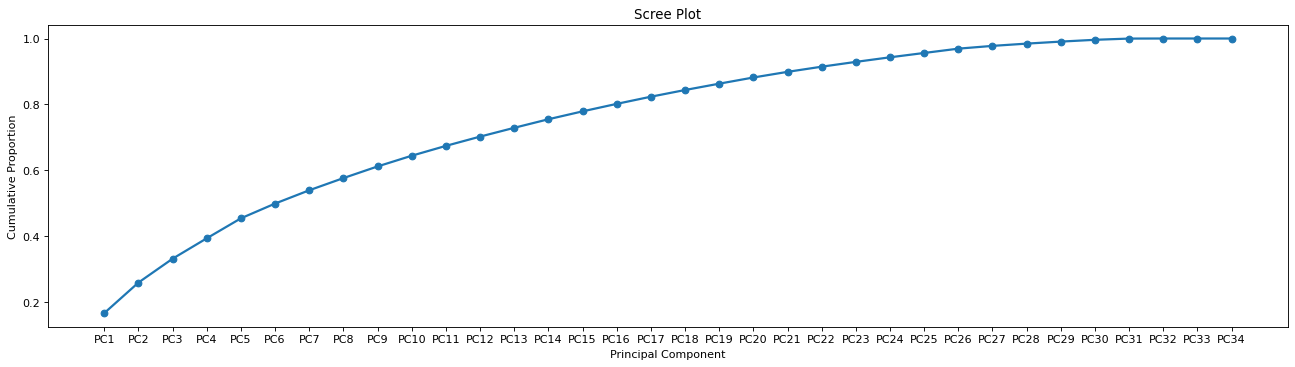

In [4]:
pcs=PCA()
pcs.fit(X_train_float)
pcsSummary_df = pd.DataFrame({'Standard Deviation': np.sqrt(pcs.explained_variance_),
                              'Proportion of Variance': pcs.explained_variance_ratio_,
                              'Cumulative Proportion': np.cumsum(pcs.explained_variance_ratio_)
                             })
pcsSummary_df = pcsSummary_df.round(4)

#pcsSummary_df.sort_values(by='Proportion of Variance',ascending =False).head(250)

pcsSummary_df = pd.DataFrame({'Standard Deviation': np.sqrt(pcs.explained_variance_),
                              'Proportion of Variance': pcs.explained_variance_ratio_,
                              'Cumulative Proportion': np.cumsum(pcs.explained_variance_ratio_)
                             })
        
# Set the columns name
pcsSummary_dft = pcsSummary_df.transpose()
pcsSummary_dft.columns=['PC{}'.format(i) for i in range(1, len(pcsSummary_dft.columns) + 1)]
# Print the table
display(pcsSummary_dft)
# Round to the fourth decimal
pcsSummary_df.round(4)
# Adjust the canvas
figure(figsize=(20, 5), dpi=80)
# Plot
plt.plot(pcsSummary_dft.columns, pcsSummary_df['Cumulative Proportion'], 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion')
plt.show()

In this case, From PC1 to PC 20 seems to be great numeric decision variables for our model since they account for 0.8 cumulative proportion in this data. 

#### Process categorical variables-ANOVA

In [5]:
model = ols('Price~Model+Fuel_Type+Color', data=dftoyota).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
Model,1.605136e+10,318.0,31.845063,0.000000
Fuel_Type,1.285081e+07,2.0,4.053760,0.017615
Color,2.930897e+07,9.0,2.054544,0.030847
Residual,1.754649e+09,1107.0,NaN,NaN


Through the ANOVA test, we know that at the 5 % level of significance, all of categorical variables are statistically insignificant since their p value are all smaller than 0.05, so I remove these categorical variables from the decision variables.

#### Transform Data

In [6]:
pcascore = pcs.transform(X_train_float)
X_train = pd.DataFrame(pcascore).iloc[:,:19]
# Set the columns name
X_train.columns=['PC{}'.format(i) for i in range(1, len(X_train.columns) + 1)]

pcascore = pcs.transform(X_test_float)#### Process categorical variables-ANOVA
X_test = pd.DataFrame(pcascore).iloc[:,:19]
# Set the columns name
X_test.columns=['PC{}'.format(i) for i in range(1, len(X_train.columns) + 1)]

### Benchmark-Linear Regression

In [7]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_train,y_train)

LinearRegression()

In [8]:
# Define Showing performance

# Creating formula

def train_test_metrics(X_train,X_test,y_train,y_test,model):
    names=['R2','MAE','MAPE'] 
    
    # Training Metrics
    y_hat = model.predict(X_train)
    
    # Create R2
    r2 = r2_score(y_train,y_hat).round(3)
    
    # Create MAE
    mae = mean_absolute_error(y_train,y_hat).round(3)
    
    # Create MAPE
    mape = mean_absolute_percentage_error(y_train,y_hat).round(3)*100
  
    # Create MSE
    #mse = (mean_squared_error(y_train,y_hat)*len(y_train)).round(3)
    
    train_metrics = [r2, mae, mape]
    train_metrics = pd.DataFrame({'Train':train_metrics},index=names)
    
    # Testing Metrics
    y_hat = model.predict(X_test)
    test_metrics = [r2_score(y_test,y_hat).round(3),
                    mean_absolute_error(y_test,y_hat).round(3),
                    mean_absolute_percentage_error(y_test,y_hat).round(3)*100,
                    #(mean_squared_error(y_test,y_hat)*len(y_test)).round(3)
                   ]
    test_metrics = pd.DataFrame({'Test':test_metrics},index=names)
    
    all_metrics = train_metrics.merge(test_metrics,left_index=True,right_index=True)
    
    #print(pd.DataFrame({'Predictor':X_train.columns}))
                       # 'coefficent':model.coef_.round(3)}))
    #print('\n')
    print(all_metrics.round(3))
    print('\n')
    
def data_model_plot(X_train,X_test,y_train,y_test,model):

    x_train_sorted = X_train.copy()
    y_train_pred = model.predict(X_train)

    x_train_sorted.insert(1,'y_train_hat',y_train_pred)
    x_train_sorted.sort_values(by='PC1',ascending=True,inplace=True)

    x_test_sorted = X_test.copy()
    y_test_pred = model.predict(X_test)

    x_test_sorted.insert(1,'y_test_hat',y_test_pred)
    x_test_sorted.sort_values(by='PC1',ascending=True,inplace=True)

    trace0 = dict(mode='markers',
                  type='scatter',
                  name='Training Data',
                  marker = dict(size=10,
                                line=dict(width=1,
                                          color='DarkSlateGrey'),
                                opacity=0.7
                               ),
                  x=X_train.iloc[:,0],
                  y=y_train,
                  xaxis='x1',
                  yaxis='y'
                 )
    trace1 = dict(mode='markers',
                  type='scatter',
                  name='Test Data',
                  marker = dict(size=10,
                                line=dict(width=1,
                                          color='DarkSlateGrey'),
                                opacity=0.7
                               ),
                  x=X_test.iloc[:,0],
                  y=y_test,
                  xaxis='x2',
                  yaxis='y'
                 )

    trace2 = dict(mode='lines',
                  type='scatter',
                  name='Model->Train',
                  x=x_train_sorted.iloc[:,0],
                  y=x_train_sorted['y_train_hat'],
                  xaxis='x1',
                  yaxis='y'
                 )
    trace3 = dict(mode='lines',
                  type='scatter',
                  name='Model->Test',
                  x=x_test_sorted.iloc[:,0],
                  y=x_test_sorted['y_test_hat'],
                  xaxis='x2',
                  yaxis='y'
                 )
    layout = dict(title='Train vs Test',
                  xaxis1 = dict(title='Explanatory Variable',
                                showgrid=False,
                                anchor='y',
                                domain=[0,0.45]
                               ),
                  xaxis2 = dict(title='Explanatory Variable',
                                showgrid=False,
                                anchor='y',
                                domain=[0.55,1]
                               ),              
                  yaxis = dict(title='Target Variable',
                               showgrid=False,
                               zeroline=False
                              ),
                  plot_bgcolor='#eee8e8',
                  height=500,
                  width=900
                 )


    plot_data = [trace0,trace1,trace2,trace3]

    # Bring data and layout objects together in a single figure
    fig = go.Figure(plot_data,layout)

    # Render the figure
    return fig.show('png')

def display_output(X_train,X_test,y_train,y_test,model):
    print(pd.DataFrame({'Predictor':X_train.columns, 'coefficent':model.coef_}))
    print('\n')
    print(train_test_metrics(X_train,X_test,y_train,y_test,model))
    print('\n')
    data_model_plot(X_train,X_test,y_train,y_test,model)

In [ ]:
train_test_metrics(X_train,X_test,y_train,y_test,Lin_reg)
data_model_plot(X_train,X_test,y_train,y_test,Lin_reg)

        Train     Test
R2      0.883    0.893
MAE   911.877  905.938
MAPE    9.100    8.900




### Ridge Regression

In [ ]:
Rig_reg = RidgeCV()
Rig_reg.fit(X_train,y_train)
train_test_metrics(X_train,X_test,y_train,y_test,Rig_reg)

### Lasso Regression

In [ ]:
Lso_reg = LassoCV()
Lso_reg.fit(X_train,y_train)
train_test_metrics(X_train,X_test,y_train,y_test,Lso_reg)

### RANSAC

In [ ]:
RAN_reg = RANSACRegressor(random_state=0).fit(X_train,y_train)
train_test_metrics(X_train,X_test,y_train,y_test,RAN_reg)

 R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

In [ ]:
pip install regressors

## Conclusion

* As the result shown above, our benchmark model linear regression has the approximate performance as Ride and Lasso. These three models appear to have same performance, and RANSAC Regression is totally worse in predict the price of these cars.